In [42]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math
import os

In [43]:
#Getting address of current working directory
curr_dir = os.getcwd()

In [44]:
#Defining Root Mean Square Log Error Function
# log(predict+1) - log(actual+1)

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [45]:
#Load Train and Test Data (which has already been pre-processed and stores in .csv files)
#enocding is used because utf-8' codec can't be decode directly
train = pd.read_csv(curr_dir+"//Dataset/train_with_brand_from_name.csv",encoding = 'ISO-8859-1') 
test = pd.read_csv(curr_dir+"//Dataset/test_with_brand_from_name.csv",encoding = 'ISO-8859-1')
#check the shape of train and test
print(train.shape) 
print(test.shape)

C:\Users\tidyq\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1482535, 10)
(693359, 9)


In [46]:
train.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3
0,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
1,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
2,6,Acacia pacific tides santorini top,3,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,Women,Swimwear,Two-Piece
3,7,Girls cheer and tumbling bundle of 7,3,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...,Sports & Outdoors,Apparel,Girls
4,8,Girls Nike Pro shorts,3,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Apparel,Girls


In [15]:
#HANDLE MISSING VALUES by putting 'missing' 
def handle_missing(dataset):
    dataset.cat_1.fillna(value="missing", inplace=True) 
    dataset.cat_2.fillna(value="missing", inplace=True)
    dataset.cat_3.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)

Handling missing values...
(1482535, 10)
(693359, 9)


In [16]:
#PROCESS CATEGORICAL DATA
#We will use Label Encoder for cat_1, cat_2, cat_3 and brand name
#also we have used np.hstack on train and test
print("Handling categorical variables...")
le = LabelEncoder()

le.fit(np.hstack([train.cat_1, test.cat_1]))
train.cat_1 = le.transform(train.cat_1)
test.cat_1 = le.transform(test.cat_1)

le.fit(np.hstack([train.cat_2, test.cat_2]))
train.cat_2 = le.transform(train.cat_2)
test.cat_2 = le.transform(test.cat_2)

le.fit(np.hstack([train.cat_3, test.cat_3]))
train.cat_3 = le.transform(train.cat_3)
test.cat_3 = le.transform(test.cat_3)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

Handling categorical variables...


In [18]:
#PROCESS TEXT: RAW
#Use tokenizer for item_desscription and name
# Then use texts_to_sequence for converting it into numerical sequence
print("Text to seq process...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")

train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())
train.head(3)

Text to seq process...
   Fitting tokenizer...
   Transforming text to seq...


,train_id,name,item_condition_id,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3,seq_item_description,seq_name
0,1,Razer BlackWidow Chroma Keyboard,3,3889,52.0,0,This keyboard is in great condition and works ...,1,30,215,"[29, 2615, 10, 7, 38, 17, 1, 207, 52, 19, 1111...","[10594, 24376, 15913, 2615]"
1,2,AVA-VIV Blouse,1,4588,10.0,1,Adorable top with a hint of lace and a key hol...,9,103,97,"[606, 60, 9, 4, 5309, 11, 193, 1, 4, 881, 1289...","[7541, 10366, 665]"
2,6,Acacia pacific tides santorini top,3,84,64.0,0,Size small but straps slightly shortened to fi...,9,98,831,"[6, 44, 39, 472, 750, 15049, 8, 100, 181, 2769...","[4760, 4810, 19944, 22172, 60]"


In [19]:
#SEQUENCES VARIABLES ANALYSIS
#We will find the maximum possible length of the name and item_description
#Although the value generated here are not used in the knn
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 269


#### These graph will help in generating Max sequence value for name and item_description

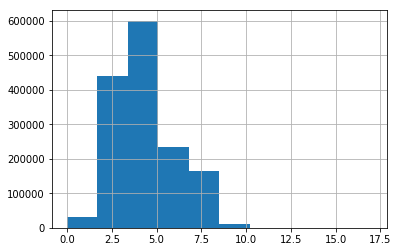

In [21]:
train.seq_name.apply(lambda x: len(x)).hist()

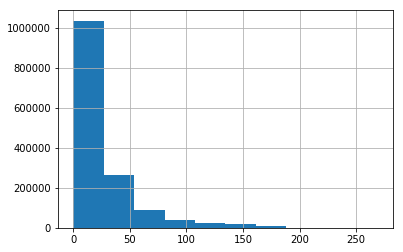

In [22]:
train.seq_item_description.apply(lambda x: len(x)).hist()

In [24]:
#EMBEDDINGS MAX VALUE
#Base on the histograms, we select the next lengths of Name_seq and Item_desc_seq
#for remaining, we will calculate the maximum value using np.max
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max())
                   , np.max(test.seq_name.max())
                  , np.max(train.seq_item_description.max())
                  , np.max(test.seq_item_description.max())])+2
MAX_CAT_1 = np.max([train.cat_1.max(), test.cat_1.max()])+1
MAX_CAT_2 = np.max([train.cat_2.max(), test.cat_2.max()])+1
MAX_CAT_3 = np.max([train.cat_3.max(), test.cat_3.max()])+1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1

In [30]:
MAX_TEXT

230141

C:\Users\tidyq\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A63D810C18>]], dtype=object)

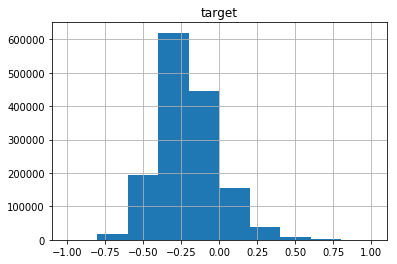

In [31]:
#SCALE target variable by first using log transform and then applying transform in the range -1 to 1
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.reshape(-1,1))
pd.DataFrame(train.target).hist()

In [32]:
#EXTRACT DEVELOPTMENT TEST
dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

(1467709, 13)
(14826, 13)


In [33]:
#KERAS DATA DEFINITION for coverting the features into a form which could be use in our neural network
#name and item_desc are converted into pad sequence
#rest are converted into numpy array
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        ,'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        ,'brand_name': np.array(dataset.brand_name)
        ,'cat_1': np.array(dataset.cat_1)
        ,'cat_2': np.array(dataset.cat_2)
        ,'cat_3': np.array(dataset.cat_3)
        ,'item_condition': np.array(dataset.item_condition_id)
        ,'num_vars': np.array(dataset[["shipping"]])
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [34]:
#Now we will define our layers and require functions

from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr_r = 0.1
    
    #Input layer having shape 1 for all features
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    cat_1 = Input(shape=[1], name="cat_1")
    cat_2 = Input(shape=[1], name="cat_2")
    cat_3 = Input(shape=[1], name="cat_3")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_cat_1 = Embedding(MAX_CAT_1, 10)(cat_1)
    emb_cat_2 = Embedding(MAX_CAT_2, 10)(cat_2)
    emb_cat_3 = Embedding(MAX_CAT_3, 10)(cat_3)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    
    #main layer with flatten to flatten the input without affecting the batch size
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_cat_1)
        , Flatten() (emb_cat_2)
        , Flatten() (emb_cat_3)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output layer which is dense
    output = Dense(1, activation="linear") (main_l)
    
    #model having mse loss and adam optimizer
    model = Model([name, item_desc, brand_name
                   , cat_1,cat_2,cat_3, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
cat_1 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
cat_2 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
cat_3 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
item_condi

In [35]:
#FITTING THE MODEL with 5epochs and batch size of 20000
BATCH_SIZE = 20000
epochs = 5

model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Train on 1467709 samples, validate on 14826 samples
Epoch 1/5
1467709/1467709 [==============================] - 520s 355us/step - loss: 0.0290 - mean_absolute_error: 0.1294 - rmsle_cust: 0.0156 - val_loss: 0.0179 - val_mean_absolute_error: 0.1006 - val_rmsle_cust: 0.0133
Epoch 2/5
1467709/1467709 [==============================] - 492s 335us/step - loss: 0.0185 - mean_absolute_error: 0.1032 - rmsle_cust: 0.0133 - val_loss: 0.0164 - val_mean_absolute_error: 0.0960 - val_rmsle_cust: 0.0126
Epoch 3/5
1467709/1467709 [==============================] - 501s 341us/step - loss: 0.0163 - mean_absolute_error: 0.0969 - rmsle_cust: 0.0127 - val_loss: 0.0157 - val_mean_absolute_error: 0.0939 - val_rmsle_cust: 0.0123
Epoch 4/5
1467709/1467709 [==============================] - 513s 350us/step - loss: 0.0151 - mean_absolute_error: 0.0930 - rmsle_cust: 0.0122 - val_loss: 0.0155 - val_mean_absolute_error: 0.0930 - val_rmsle_cust: 0.0122
Epoch 5/5
1467709/1467709 [==============================] - 500

In [37]:
#EVLUEATE THE MODEL ON DEV TEST
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

 RMSLE error on dev test: 0.4849776160365398


In [38]:
#CREATE PREDICTIONS by applying inverse transformation and exponential on predicted value
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test[["test_id"]]
submission["price"] = preds

C:\Users\tidyq\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


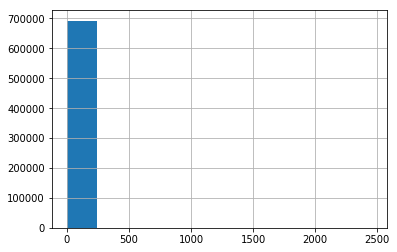

In [39]:
submission.to_csv("./myNNsubmission.csv", index=False)
submission.price.hist()